## Reloading Julia Sim

### Set Up Model

In [50]:
OUTPUT_FOLDER_PRE = "C:/Users/Yan/OneDrive/Desktop/UNI/Honours/ml-for-da-yanny-honours-2025/"
LAYER_FOLDER = "one_layer_up_to_training"
OG_REANALYSIS_NC = "one_layer_primitive_wet/output.nc"
REANALYSIS_NPZ = "reanalysis/speedy_1layer_vor_div_reanalysis.npz"
SAVE_FOLDER ="restart_runs"

using SpeedyWeather
using NCDatasets
using LinearAlgebra
using CairoMakie

spectral_grid = SpectralGrid(NF = Float64, trunc = 31, nlayers=1, Grid=FullGaussianGrid{Float64})
output = NetCDFOutput(spectral_grid, path=OUTPUT_FOLDER_PRE*SAVE_FOLDER)

@kwdef struct TempOutput <: SpeedyWeather.AbstractOutputVariable
    name::String = "temp"
    unit::String = "K"
    long_name::String = "temperature"
    dims_xyzt::NTuple{4, Bool} = (true, true, true, true)
end

@kwdef struct SurPresOutput <: SpeedyWeather.AbstractOutputVariable
    name::String = "spres"
    unit::String = "Pa"
    long_name::String = "surface pressure"
    dims_xyzt::NTuple{4, Bool} = (true, true, false, true)
end

@kwdef struct DivOutput <: SpeedyWeather.AbstractOutputVariable
    name::String = "div"
    unit::String = "s^-1"
    long_name::String = "divergence"
    dims_xyzt::NTuple{4, Bool} = (true, true, true, true)
end

@kwdef struct HumidOutput <: SpeedyWeather.AbstractOutputVariable
    name::String = "humid"
    unit::String = ""
    long_name::String = "specific humidity"
    dims_xyzt::NTuple{4, Bool} = (true, true, true, true)
end

@kwdef struct PrecipOutput <: SpeedyWeather.AbstractOutputVariable
    name::String = "precip"
    unit::String = ""
    long_name::String = "precipitation"
    dims_xyzt::NTuple{4, Bool} = (true, true, false, true)
end


add!(output, TempOutput(), SurPresOutput(), DivOutput(), HumidOutput(), SpeedyWeather.PrecipitationOutput()...)
SpeedyWeather.path(::TempOutput, simulation) =
    simulation.diagnostic_variables.grid.temp_grid
SpeedyWeather.path(::SurPresOutput, simulation) =
    simulation.diagnostic_variables.grid.pres_grid
SpeedyWeather.path(::DivOutput, simulation) =
    simulation.diagnostic_variables.grid.div_grid
SpeedyWeather.path(::HumidOutput, simulation) =
    simulation.diagnostic_variables.grid.humid_grid
    
time_stepping = Leapfrog(spectral_grid, Δt_at_T31=Minute(30))
ocean = ConstantOceanClimatology(spectral_grid)
planet = Earth(spectral_grid, seasonal_cycle = true, equinox = DateTime(2000, 3, 20))
convection = SimplifiedBettsMiller(spectral_grid)
large_scale_condensation = ImplicitCondensation(spectral_grid)
temperature_relaxation = JablonowskiRelaxation(spectral_grid)
model = PrimitiveWetModel(spectral_grid; output, time_stepping, temperature_relaxation, planet, ocean)
orography = EarthOrography(spectral_grid)
initialize!(orography, model) 
simulation = initialize!(model)

Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

In [95]:
# Load restart variables
initialize!(simulation.prognostic_variables, StartFromFile(path=LAYER_FOLDER), model)
keys(ds_for_restart)

17-element Vector{String}:
 "time"
 "lon"
 "lat"
 "layer"
 "soil_layer"
 "precip_cond"
 "cloud_top"
 "v"
 "humid"
 "temp"
 "spres"
 "u"
 "div"
 "precip_conv"
 "vor"
 "precip_cond_rate"
 "precip_conv_rate"

In [ ]:
using NPZ

# load in timestep before restart 
ds_reanalysis = NCDataset(OUTPUT_FOLDER_PRE*OG_REANALYSIS_NC)
ds_reanalysis_npz = npzread("reanalysis/speedy_1layer_u_v_reanalysis.npz")
ds_restart_no_lf = NCDataset("restart_runs/run_0001/output.nc")

start_t = 29221 # 2021-01-01 start 
restart_date = start_t + 365*4*10
finish_t = start_t + 365*4*15 #15 years

println("The first time stamp on the simulation from restart, ", ds_restart_no_lf["time"][1])
println("The initial condition time stamp loaded in for restart is, ", simulation.prognostic_variables.clock.time)
println("The renalaysis idx for ", ds_reanalysis["time"][restart_date], " in reanalysis is : ", restart_date)

t = 1
var_name = "humid"
diff_states = Float64.(ds_restart_no_lf[var_name][:,:, 1, 1 + t]) - Float64.(ds_reanalysis[var_name][:,:, 1, restart_date + t])
println("The 2-norm of difference in states for ", var_name, " is, ", norm(diff_states))
println("The 2-norm for the state ", var_name, " is, ", norm(Float64.(ds_reanalysis[var_name][:,:, 1, restart_date + t])))
# println(diff_states)

heatmap(FullGaussianField(diff_states, input_as=Matrix), title = "Temperature difference (K), $( ds_reanalysis["time"][restart_date + 1])")


# ========== FULL STATES========================================
# t = start_t + 10000
# target_date = ds_reanalysis["time"][t]
# spres_map = heatmap(FullGaussianField(Float64.(ds_reanalysis["spres"][:,:, t]), input_as=Matrix); 
#     title = "Surface Pressure (log Pa), $(target_date)")
# temp_map = heatmap(FullGaussianField(Float64.(ds_reanalysis["temp"][:,:,1, t]), input_as=Matrix); title="Temperature (K), $(target_date)")
# u_map = heatmap(FullGaussianField(Float64.(ds_reanalysis["u"][:,:,1, t]), input_as=Matrix), title="u wind (m/s), $(target_date)")
# v_map = heatmap(FullGaussianField(Float64.(ds_reanalysis["v"][:,:,1, t]), input_as=Matrix), title="v wind (m/s), $(target_date)")
# vor_map = heatmap(FullGaussianField(Float64.(ds_reanalysis["vor"][:,:,1, t]), input_as=Matrix), title="vorticity (s⁻¹), $(target_date)")
# div_map = heatmap(FullGaussianField(Float64.(ds_reanalysis["div"][:,:,1, t]), input_as=Matrix), title="divergence (s⁻¹), $(target_date)")
# humid_map = heatmap(FullGaussianField(Float64.(ds_reanalysis["humid"][:, :, 1, t]), input_as=Matrix), title="specific humidity (kg/kg), $(target_date)")


The first time stamp on the simulation from restart, 2030-12-30T00:00:00
The initial condition time stamp loaded in for restart is, 2030-12-30T00:00:00
The renalaysis idx for 2030-12-30T00:00:00 in reanalysis is : 43821
The 2-norm of difference in states for humid is, 6.2434771181828615e-6
The 2-norm for the state humid is, 0.0002352633318913927


21901×48×96 Array{Float32, 3}:
[:, :, 1] =
 202.071  202.08   202.225  202.426  …  201.968  202.032  202.011  201.759
 202.071  202.08   202.225  202.426     201.969  202.033  202.011  201.759
 202.071  202.08   202.225  202.426     201.969  202.033  202.012  201.76
 202.071  202.08   202.225  202.426     201.97   202.034  202.012  201.76
 202.071  202.08   202.225  202.426     201.97   202.034  202.013  201.761
 202.071  202.08   202.225  202.426  …  201.97   202.034  202.013  201.761
 202.071  202.08   202.225  202.426     201.97   202.034  202.013  201.761
 202.071  202.08   202.225  202.426     201.97   202.034  202.013  201.761
 202.071  202.079  202.225  202.426     201.97   202.034  202.013  201.761
 202.071  202.079  202.225  202.426     201.97   202.034  202.013  201.761
 202.071  202.079  202.225  202.426  …  201.97   202.034  202.013  201.761
 202.071  202.079  202.224  202.426     201.97   202.034  202.013  201.761
 202.071  202.079  202.224  202.426     201.97   202.034  2

In [186]:
methods(heatmap!)

# 1 method for generic function "heatmap!" from Makie:
 [1] heatmap!(args...; kw...)
     @ C:\Users\Yan\.julia\packages\Makie\6zcxH\src\recipes.jl:519

### Is running the simulation from start the same

In [4]:
run!(simulation, period=Day(50), output=true)#10955), output=true)

Weather is speedy: run 0001 100%|█████████| Time: 0:00:07 (1607.65 years/day)


Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

In [ ]:
using NPZ

ds_reanalysis = NCDataset(OUTPUT_FOLDER_PRE*OG_REANALYSIS_NC)

#length of time
start_t = 29221 # 2021-01-01 start 
finish_t = start_t + 365*4*15 #15 years
all_time = ds_reanalysis["time"][:]
times = ds_reanalysis["time"][start_t : finish_t]
time_len = size(times)[1]
lat_count = 48
lon_count = 96
year_steps = 1460

ds_restart = NCDataset("restart_runs/run_0001/output.nc")
ds_npz = npzread(REANALYSIS_NPZ)

println(ds_restart["time"][1])
println(ds_reanalysis["time"][start_t+365*4*10])

2030-12-30T00:00:00
2030-12-30T00:00:00


In [48]:
ds_restart["time"]

time (201)
  Datatype:    DateTime (Float64)
  Dimensions:  time
  Attributes:
   units                = hours since 2000-01-01 00:00:0.0
   calendar             = proleptic_gregorian
   long_name            = time
   standard_name        = time


In [62]:
sqrt(norm(difference[25:50,1:10]))

0.3478618f0

0.32360968
27.897314


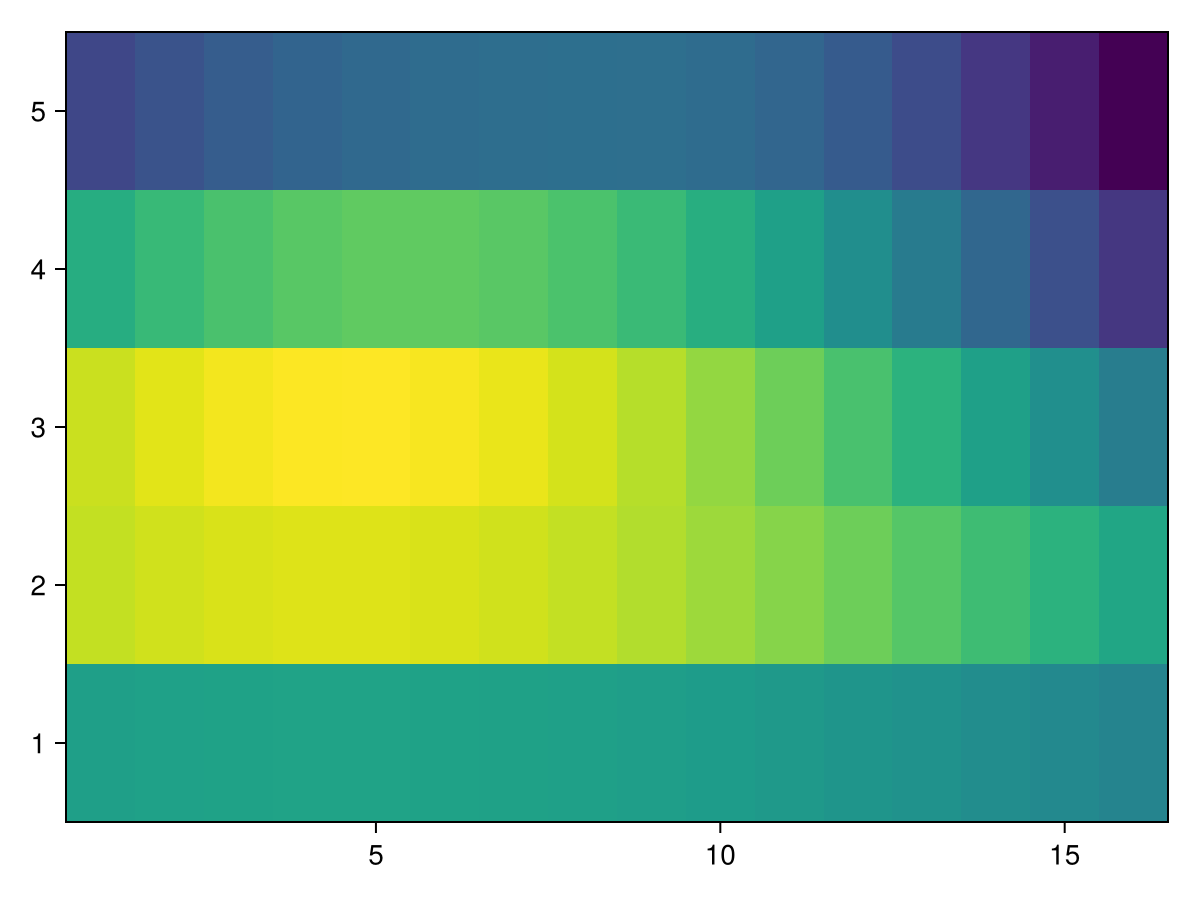

In [ ]:
difference = ds_reanalysis["spres"][:,:,start_t+365*4*10+180] - ds_restart["spres"][:,:,1+180]
println()

### Find Perturbation

In [4]:
using NPZ
using NCDatasets
using CairoMakie

data_npz = npzread(REANALYSIS_NPZ)
ds = NCDataset(OUTPUT_FOLDER_PRE*OG_REANALYSIS_NC)

#length of time
start_t = 29221 # 2021-01-01 start 
finish_t = start_t + 365*4*15 #15 years
all_time = ds["time"][:]
times = ds["time"][start_t : finish_t]
time_len = size(times)[1]
lat_count = 48
lon_count = 96
year_steps = 1460

print("Is the start of the reanalysis ", start_t, " time steps away from 2001-01-01 ? \n")
print(data_npz["vorticity"][1,:,:] == permutedims(ds["vor"][:,:,1,start_t], (2,1)))

print("\nHence (finish_t - 500) same as (end - 500) in reanalysis.npz will still be within the testing dataset\n")
print(data_npz["divergence"][end-500,:,:] == permutedims(ds["div"][:,:,1,finish_t-500], (2,1)))

prog_variables = ["temperature", "humidity", "vorticity", "divergence", "surface_pressure"]
prog_data_pert = Dict{String, Any}()
prog_pert_field = Dict{String, Any}()
for key in prog_variables
    prog_data_pert[key] = Float64.(data_npz[key][end - 500, :, :]) - Float64.(data_npz[key][end - 528, :, :])
    prog_pert_field[key] = FullGaussianGrid(prog_data_pert[key], input_as=Matrix)
end
typeof(prog_pert_field["temperature"])

Is the start of the reanalysis 29221 time steps away from 2001-01-01 ? 
true
Hence (finish_t - 500) same as (end - 500) in reanalysis.npz will still be within the testing dataset
true

Field{Float64, 1, Vector{Float64}, FullGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}

In [5]:
# spectral_grid = SpectralGrid(NF = Float64, trunc = 31, nlayers=1, Grid=FullGaussianGrid{Float64})
S_fp64 = SpectralTransform(spectral_grid)
pert_grid_to_spectral = Dict{String, Any}()
a = Dict{String, Any}()
b = Dict{String, Any}()
back_to_grid = Dict{String,Any}()

for key in prog_variables
    pert_grid_to_spectral[key] = transform(prog_pert_field[key], S_fp64)
    a[key] = transform(pert_grid_to_spectral[key], S_fp64)
    b[key] = transform(a[key], S_fp64)
    back_to_grid[key] = transform(b[key], S_fp64)
end

print(norm(prog_pert_field["divergence"]))
prog_pert_field["divergence"]-back_to_grid["divergence"]

0.3083069258870492

4608-element, 48-ring FullGaussianField{Float64, 1} on Array on SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}:
  0.0024536797396203422
  0.00037920673323062757
 -0.0032932308608680117
 -0.0024772978119675876
  0.0007741491587580866
  0.0013443345741150838
 -0.00012637702654053922
 -0.0017917331384175626
 -0.0039389267943998486
 -0.003910463521212812
  0.0009646397907286437
  0.005423852426622912
  0.00351797659467295
  ⋮
  0.001055805603278618
  0.0015164378039087302
  0.001200198423696103
  0.0008646909932005144
  0.0012347131101667365
  0.0011982060167778131
  0.0006926693118118037
  0.0006942232539931116
  0.000470976951647502
 -0.00044069335153678734
 -0.000715088006162623
 -0.0003177259814432586

In [6]:
L = zeros(LowerTriangularArray{ComplexF64}, 33, 32, 1, 2)

vor_pert = copy(L)
vor_pert[:, :, 1] = transform(prog_pert_field["vorticity"], S_fp64)

div_pert = copy(L)
div_pert[:, :, 1] = transform(prog_pert_field["divergence"], S_fp64)
# typeof(v_pert)
sv = view(div_pert, :, :, 1)
typeof(vor_pert)

LowerTriangularArray{ComplexF64, 3, Array{ComplexF64, 3}, Spectrum{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}

In [7]:
println("Before peturbing")
vor_pre = copy(simulation.prognostic_variables.vor)
div_pre = copy(simulation.prognostic_variables.div)

set!(simulation.prognostic_variables.vor, vor_pert; add=true)
set!(simulation.prognostic_variables.div, div_pert; add=true)

Before peturbing


560×1×2 LowerTriangularArray{ComplexF64, 3, Array{ComplexF64, 3}, Spectrum{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}
[:, :, 1] =
 -0.00016544507801278169 + 0.0im
  -0.0003190831339096819 + 0.0im
  -0.0007121958009527834 + 0.0im
   0.0004529180831080081 + 0.0im
   0.0016819455870141717 + 0.0im
  -0.0004463570225592156 + 0.0im
  -0.0009161660330566078 + 0.0im
  -0.0009230481734261543 + 0.0im
   -0.000826904405454058 + 0.0im
   0.0017288658646194325 + 0.0im
    0.001367230934107862 + 0.0im
  -0.0011489303887033324 + 0.0im
  -0.0012034804448073043 + 0.0im
                         ⋮
 -0.00014559463073641202 - 0.00020664139657063115im
  -0.0001421905947305142 + 9.1679995123492e-5im
  -0.0001503979423747676 - 7.368110974644898e-5im
   2.7210188012828514e-5 - 1.6289576439006912e-5im
  -3.0288281128444567e-6 + 1.0116006198248816e-5im
  -2.5849775371005597e-5 + 7.00170839962246e-6im
    4.180726455757126e-6 - 9.633413828600257e-6im
 -0.000

In [ ]:
println("norm of perturbation divergence: ", norm(div_pert))
println("norm of perturbation vorticity: ", norm(vor_pert))

println("Back to grid space???")
div_diff_grid = transform(simulation.prognostic_variables.div, S_fp64) - transform(div_pre, S_fp64)
div_pert_grid = transform(div_pert, S_fp64)
println(norm(div_pert_grid - div_diff_grid)/norm(div_pert))

norm of perturbation divergence: 0.011750413272946892
norm of perturbation vorticity: 1.0714669510680934e-7
Back to grid space???
7.126754185084194e-15


In [6]:
rotate_map(x::Any) = permutedims(x, (1,2))

fig = Figure(size=(800, 1000))
ax1, hm1 = heatmap(fig[1,1], permutedims(rotate_map(prog_data_pert["temperature"])), colormap=:viridis)
ax1.yreversed=true
Colorbar(fig[1,2], hm1)

ax2, hm2 = heatmap(fig[2,1], permutedims(rotate_map(data_npz["temperature"][end - 500, :, :])), colormap=:viridis)
Colorbar(fig[2,2], hm2)
ax2.yreversed=true
# fig


true